In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# 残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        #两个3*3的卷积层
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            #1*1卷积层
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class Bottleneck(nn.Module):
    def __init__(self, in_channel, out_channel, strides=1, same_shape=True, bottle=True):
        super(Bottleneck, self).__init__()
        self.same_shape = same_shape
        self.bottle = bottle
        if not same_shape:
            strides = 2
        self.strides = strides
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=strides, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel*4, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel*4)
        )
        if not same_shape or not bottle:
            self.conv4 = nn.Conv2d(in_channel, out_channel*4, kernel_size=1, stride=strides, bias=False)
            self.bn4 = nn.BatchNorm2d(out_channel*4)
            print(self.conv4)
    def forward(self, x):
        print(x.size())
        out = self.block(x)
        print(out.size())
        if not self.same_shape or not self.bottle:
            x = self.bn4(self.conv4(x))
        return F.relu(out + x)
    
class ResNet(nn.Module):
    def __init__(self, block, in_channels,num_blocks, num_classes=10):
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, 64, num_blocks[0], first_block=True)
        self.layer2 = self.make_layer(block, 64, 128, num_blocks[1])
        self.layer3 = self.make_layer(block, 128, 256, num_blocks[2])
        self.layer4 = self.make_layer(block, 256, 512, num_blocks[3])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4 if block == Bottleneck else 512, num_classes)

    def make_layer(block, input_channels, num_channels, num_blocks, first_block=False):
        layers = []
        for i in range(num_blocks):
            if i == 0 and not first_block:
                layers.append(block(input_channels, num_channels, use_1x1conv=True, strides=2))
            else:
                layers.append(block(num_channels, num_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Using device: cuda
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
torch.Size([64, 1, 28, 28])
Epoch 1, Batch [100/938], AvgLoss: 0.7068
Epoch 1, Batch [200/938], AvgLoss: 0.1730
Epoch 1, Batch [300/938], AvgLoss: 0.1242
Epoch 1, Batch [400/938], AvgLoss: 0.1014
Epoch 1, Batch [500/938], AvgLoss: 0.0794
Epoch 1, Batch [600/938], AvgLoss: 0.0789
Epoch 1, Batch [700/938], AvgLoss: 0.0761
Epoch 1, Batch [800/938], AvgLoss: 0.0559
Epoch 1, Batch [900/938], AvgLoss: 0.0708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_accuracy = 95.71%, validate_accuracy = 95.81%
(28, 28)
(28, 28, 3)


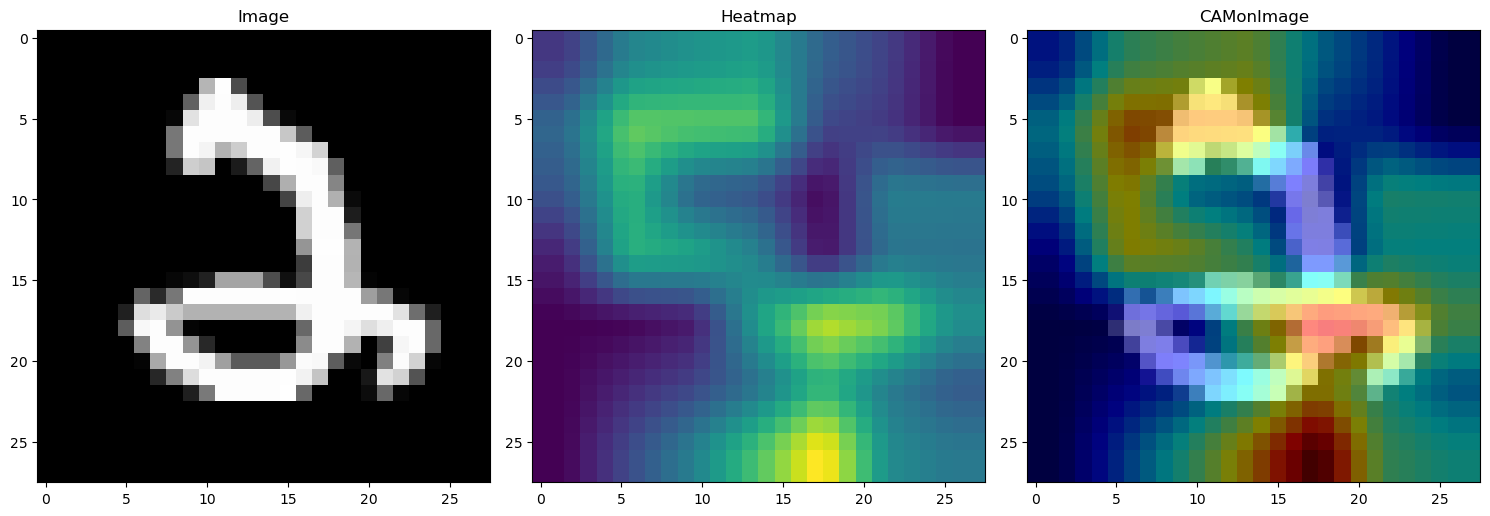

Epoch 2, Batch [100/938], AvgLoss: 0.0541
Epoch 2, Batch [200/938], AvgLoss: 0.0532
Epoch 2, Batch [300/938], AvgLoss: 0.0477
Epoch 2, Batch [400/938], AvgLoss: 0.0446
Epoch 2, Batch [500/938], AvgLoss: 0.0600
Epoch 2, Batch [600/938], AvgLoss: 0.0483
Epoch 2, Batch [700/938], AvgLoss: 0.0470
Epoch 2, Batch [800/938], AvgLoss: 0.0491
Epoch 2, Batch [900/938], AvgLoss: 0.0403


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_accuracy = 97.5933%, validate_accuracy = 97.6%
(28, 28)
(28, 28, 3)


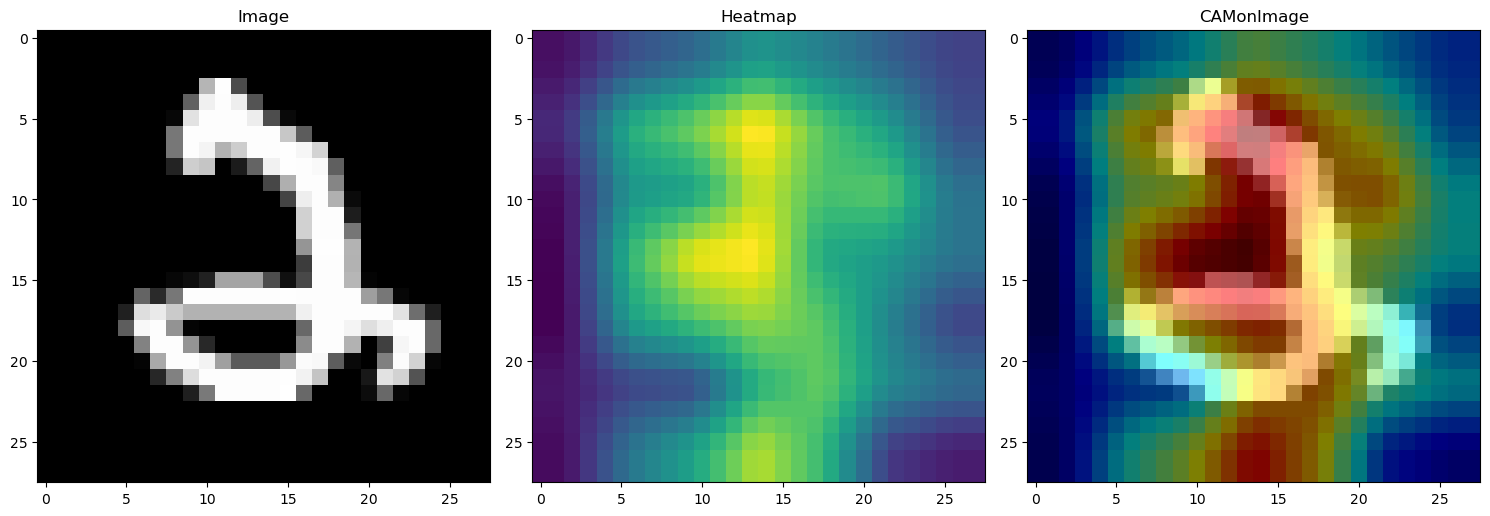

Epoch 3, Batch [100/938], AvgLoss: 0.0377
Epoch 3, Batch [200/938], AvgLoss: 0.0319
Epoch 3, Batch [300/938], AvgLoss: 0.0350
Epoch 3, Batch [400/938], AvgLoss: 0.0354
Epoch 3, Batch [500/938], AvgLoss: 0.0410
Epoch 3, Batch [600/938], AvgLoss: 0.0405
Epoch 3, Batch [700/938], AvgLoss: 0.0382
Epoch 3, Batch [800/938], AvgLoss: 0.0347
Epoch 3, Batch [900/938], AvgLoss: 0.0381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_accuracy = 99.3233%, validate_accuracy = 98.96000000000001%
(28, 28)
(28, 28, 3)


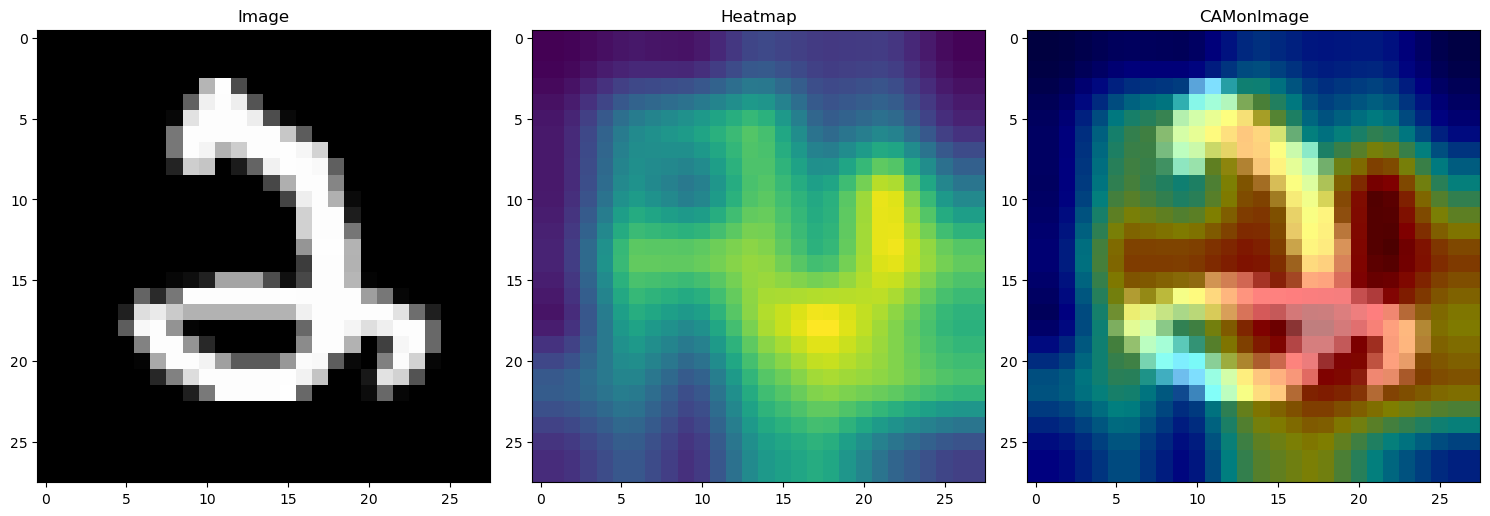

Epoch 4, Batch [100/938], AvgLoss: 0.0243
Epoch 4, Batch [200/938], AvgLoss: 0.0305
Epoch 4, Batch [300/938], AvgLoss: 0.0247
Epoch 4, Batch [400/938], AvgLoss: 0.0356
Epoch 4, Batch [500/938], AvgLoss: 0.0339
Epoch 4, Batch [600/938], AvgLoss: 0.0311
Epoch 4, Batch [700/938], AvgLoss: 0.0374
Epoch 4, Batch [800/938], AvgLoss: 0.0363
Epoch 4, Batch [900/938], AvgLoss: 0.0242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_accuracy = 98.55000000000001%, validate_accuracy = 98.4%
(28, 28)
(28, 28, 3)


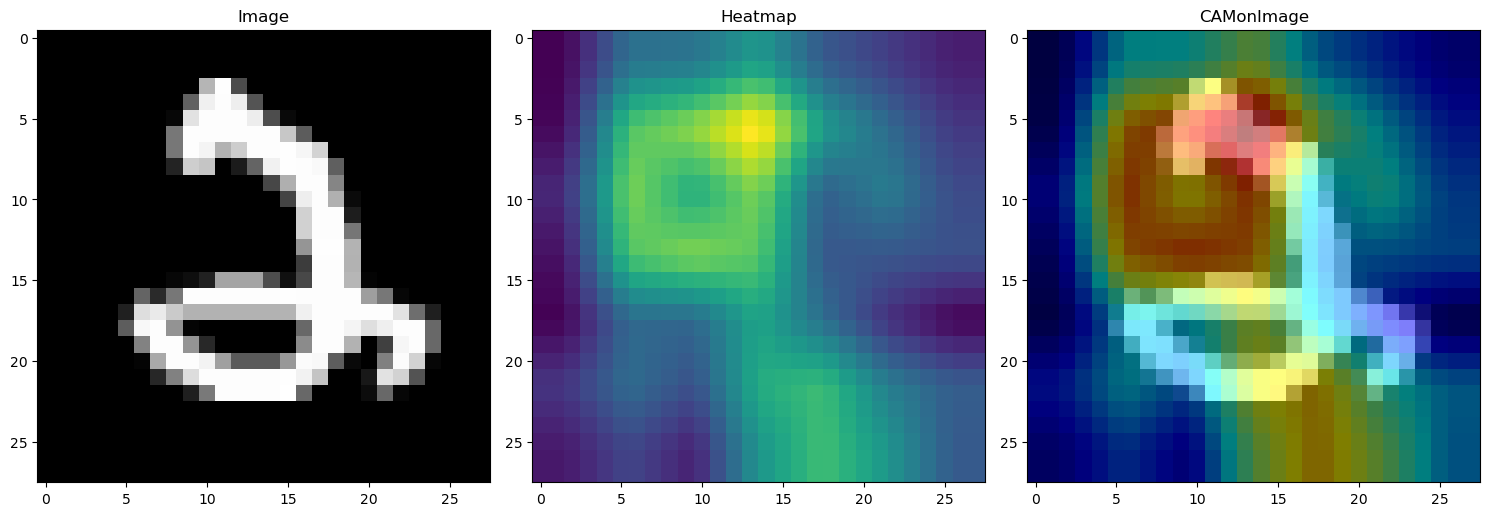

Epoch 5, Batch [100/938], AvgLoss: 0.0208
Epoch 5, Batch [200/938], AvgLoss: 0.0183
Epoch 5, Batch [300/938], AvgLoss: 0.0253
Epoch 5, Batch [400/938], AvgLoss: 0.0214
Epoch 5, Batch [500/938], AvgLoss: 0.0360
Epoch 5, Batch [600/938], AvgLoss: 0.0242
Epoch 5, Batch [700/938], AvgLoss: 0.0281
Epoch 5, Batch [800/938], AvgLoss: 0.0268
Epoch 5, Batch [900/938], AvgLoss: 0.0238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_accuracy = 99.37%, validate_accuracy = 99.11%
(28, 28)
(28, 28, 3)


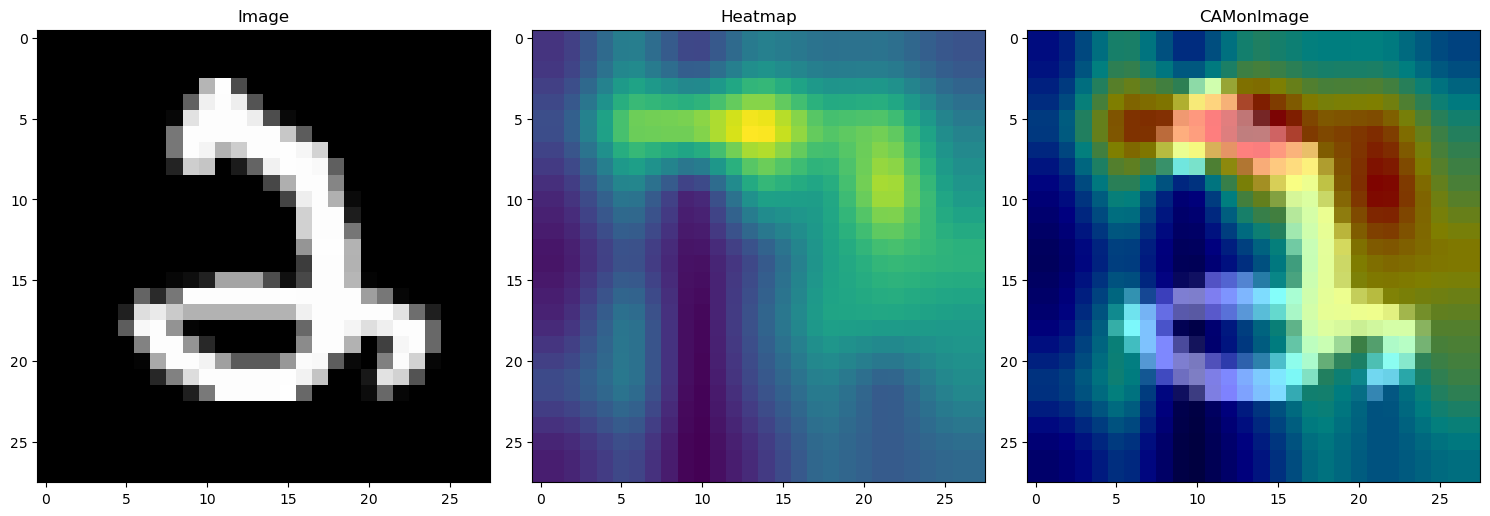

Model save to mnist_ResNet2
Train finished, Export Model to mnist_ResNet2_onnx.onnx


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models
import time
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn.functional as F

# 残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(*resnet_block(64, 64, num_blocks[0], first_block=True))
        self.layer2 = nn.Sequential(*resnet_block(64, 128, num_blocks[1]))
        self.layer3 = nn.Sequential(*resnet_block(128, 256, num_blocks[2]))
        self.layer4 = nn.Sequential(*resnet_block(256, 512, num_blocks[3])) if num_blocks[3] > 0 else nn.Identity()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        final_out_channels = self.get_final_out_channels(block, num_blocks)
        self.fc = nn.Linear(final_out_channels if block == Residual else 2048, num_classes)

    def get_final_out_channels(self, block, num_blocks):
        # 计算最终的输出通道数
        layers = [64, 128, 256, 512]
        for i in range(4):
            if num_blocks[i] == 0:
                return layers[i-1] if i > 0 else 64
        return layers[3] if block == Residual else layers[3] * 4
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# CAM通过替换全连接层为GAP层，重新训练得到权重，而Grad-CAM另辟蹊径，用梯度的全局平均来计算权重。事实上，经过严格的数学推导，Grad-CAM与CAM计算出来的权重是等价的。
# 定义训练函数
def train(model, device:torch.device, writer_epoch:SummaryWriter, data_loader:DataLoader, optimizer:optim, criterion, epoch)->None:
    watch_batch_size = 100
    model.train()
    avg_loss = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        if batch_idx % watch_batch_size == (watch_batch_size - 1):  # 每100个batch打印一次
            avg_loss =  avg_loss / watch_batch_size
            writer_epoch.add_scalars('training loss pre batch', {f'avg_loss{epoch+1}': avg_loss}, batch_idx + 1)
            print(f'Epoch {epoch + 1}, Batch [{batch_idx + 1}/{len(data_loader)}], AvgLoss: {avg_loss:.4f}')
            avg_loss = 0.0

# 定义验证函数
def evaluate(model, device:torch.device, data_loader:DataLoader, criterion) ->tuple[float, float]:
    data_len = 0
    model.eval()
    loss = 0.0
    correct_count = 0.0
    first_batch = next(iter(data_loader))[0]
    # print('first_batch.shape', first_batch.shape)
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            # print(target.shape) # 一个64维的行向量，代表整个64张图的batch中每个图的代表的数字
            # print(data.shape)
            output = model(data)
            # print(output.shape) # 64行10列表示这个batch中的64张图对应到每个数字（0-9）的概率。
            loss += criterion(output, target).item()  # 累积损失
            data_len += 1
            pred = output.argmax(dim=1, keepdim=True)
            correct_count += pred.eq(target.view_as(pred)).sum().item()
    loss = loss / data_len
    accuracy = correct_count / len(data_loader.dataset)
    return accuracy, loss, first_batch

def main():
    # 设置设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')
    
    # 设置超参
    model_name = 'ResNet2'
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5
    
    # 加载MNIST数据集
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    print(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    validate_dataset = datasets.MNIST('./data', train=False, transform=transform)
    print(validate_dataset)
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)
    
    # 创建自定义ResNet2模型实例
    model = ResNet(Residual, [1, 1, 0, 0]).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    # 获取当前时间戳
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    log_dir = f"runs/{model_name}_experiment_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)
    
    # 添加模型结构到TensorBoard
    writer_model = SummaryWriter(log_dir)
    data_iter = iter(train_loader)
    images, _ = next(data_iter)
    print(images.shape)
    writer_model.add_graph(model, images.to(device))
    
    # model.load_state_dict(torch.load('mnist_ResNet18.pth'))
    
    # 训练和验证循环
    for epoch in range(num_epochs):
        # 初始化writer_epoch
        writer_epoch = SummaryWriter(log_dir)
        
        epoch_start_time = time.time()
        
        train(model, device, writer_epoch, train_loader, optimizer, criterion, epoch)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        writer_epoch.add_scalar('epoch_duration (seconds)', epoch_duration, epoch+1)

        train_accuracy, train_loss, batch0 = evaluate(model, device, train_loader, criterion)
        validate_accuracy, validate_loss, _ = evaluate(model, device, validate_loader, criterion)
        print(f'train_accuracy = {round(train_accuracy, 6) * 100}%, validate_accuracy = {round(validate_accuracy, 6) * 100}%')
        
        
        writer_epoch.add_scalars('accurancy', {'train accurancy': train_accuracy, 
                                               'validate accurancy':validate_accuracy},global_step=epoch+1)
        writer_epoch.add_scalars('loss', {'train loss': train_loss, 
                                          'validate loss':validate_loss},global_step=epoch+1)

        img_grid = make_grid(batch0, nrow=8, normalize=False, scale_each=False)
        writer_epoch.add_image(f'batch0_imgs{epoch+1}', img_grid, global_step=None)
        
        # 生成Grad-CAM heatmap（对一个图像）
        target_layers = [model.layer2[-1]]
        # target_layers = [model.resnet50.layer4[-1]]
        cam = GradCAM(model=model, target_layers=target_layers)
        mask = cam(input_tensor=images)[0, :] # (H, W, C)
        
        # 转换成图像
        gray_img = images[0].cpu().squeeze().numpy() # 现在只取一个batch的第一张图演示
        print(gray_img.shape)
        rgb_img_hwc = np.repeat(gray_img[:, :, np.newaxis], 3, axis=2) # (H, W, C)
        print(rgb_img_hwc.shape)
        rgb_img_hwc = cv2.normalize(rgb_img_hwc, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        visualization_c3u8_rgb = show_cam_on_image(rgb_img_hwc, mask, use_rgb=True)
        
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(rgb_img_hwc)  # 第一个图的示例数据
        axs[0].set_title('Image')
        axs[1].imshow(mask)  # 第二个图的示例数据
        axs[1].set_title('Heatmap')
        axs[2].imshow(visualization_c3u8_rgb)  # 第三个图的示例数据
        axs[2].set_title('CAMonImage')

        plt.tight_layout()
        plt.show()
        
        
        rgb_img_hwc_c3u8 = cv2.normalize(rgb_img_hwc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
        
        img_tensor = torch.from_numpy(rgb_img_hwc_c3u8).permute(2, 0, 1).unsqueeze(0)  # 将形状从 [H, W, C] 调整为 [B, C, H, W]
        visualization_tensor = torch.from_numpy(visualization_c3u8_rgb).permute(2, 0, 1).unsqueeze(0) # 将形状从 [H, W, C] 调整为 [B, C, H, W]
        cam_images_tensor = torch.cat((img_tensor, visualization_tensor), dim=0)
        
        writer_epoch.add_images("cam_images", cam_images_tensor, global_step=epoch+1)
        
    # 保存训练模型和参数
    torch.save(model.state_dict(), f'mnist_{model_name}.pth')
    print(f"Model save to mnist_{model_name}")
    
    
    dummy_input_shape = (1, 1, 28, 28)  # MNIST图像为28x28像素，单通道
    dummy_input = torch.randn(tuple(dummy_input_shape)).to(device)  # 创建一个虚拟输入张量
    onnx_file_path = f"mnist_{model_name}_onnx.onnx"
    torch.onnx.export(model, dummy_input, onnx_file_path, export_params=True, opset_version=17, do_constant_folding=True)

    print(f"Train finished, Export Model to {onnx_file_path}")

    writer_epoch.close()
    
if __name__ == "__main__":
    main()